In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from iads.recommandation.prediction import get_cosine_matrix, get_kernel_matrix

import warnings
warnings.filterwarnings('ignore')

# I. Chargement des données :

In [4]:
df_jeux = pd.read_csv("../data/details_desc.csv")
df_jeux.head(2)

,Nombre d'avis,full_title,Note rectifiée,Note,Note Finkel,categories,Nombre d'avis rectifiés,description,titre,_id,...,distributors,nb_players,age_required,duration,enfant,ado,adulte,solo,duo,multi
0,19.0,Marvel United (2020),8.40,7.58,8.74,NaN,10.0,marvel united unir contre super vilain red sku...,Marvel United,marvel-united,...,NaN,1-4,14-99,45.0,0,1,1,1,0,1
1,33.0,Mariposas (2020),7.29,7.39,7.68,NaN,17.0,annee printemps million papillon monarque quit...,Mariposas,mariposas,...,NaN,2-5,14-99,60.0,0,1,1,0,1,1


In [5]:
nb_desc_isna = len(df_jeux[df_jeux["description"].isna()])
nb_jeux = len(df_jeux)
print(nb_desc_isna, "descriptions manquantes sur", nb_jeux )
print(f"Soit {round((nb_desc_isna/nb_jeux)*100,3)}%")

1957 descriptions manquantes sur 16873
Soit 11.598%


In [6]:
desc_notna = df_jeux["description"].notna()
cat_notna = df_jeux["categories"].notna()

df_jeux_nona = df_jeux[desc_notna & cat_notna].reset_index(drop=True)

# II. Descriptions

Créer une matrice de similarité pondérée sur plusieurs caractéristiques des les jeux :

In [7]:
col_weights = {"'description'": 0.4,
            "'categories'":0.3,
            "['enfant','ado','adulte']":0.15,
            "['solo', 'duo', 'multi']":0.15} 

- Avec cosine : 

In [8]:
cosine_matrix = np.zeros((len(df_jeux_nona), len(df_jeux_nona)))

for col, weight in tqdm(col_weights.items()):
    similarity_matrix = get_cosine_matrix(df_jeux_nona, eval(col))
    cosine_matrix += similarity_matrix * weight

100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


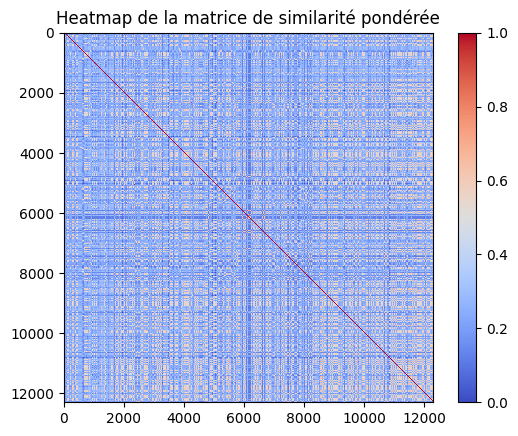

In [9]:
plt.imshow(cosine_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Heatmap de la matrice de similarité pondérée')
plt.colorbar()
plt.show()

- Kernel linear 

In [10]:
linear_matrix = np.zeros((len(df_jeux_nona), len(df_jeux_nona)))

for col, weight in tqdm(col_weights.items()):
    similarity_matrix = get_kernel_matrix(df_jeux_nona, eval(col), "linear")
    linear_matrix += similarity_matrix * weight

100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


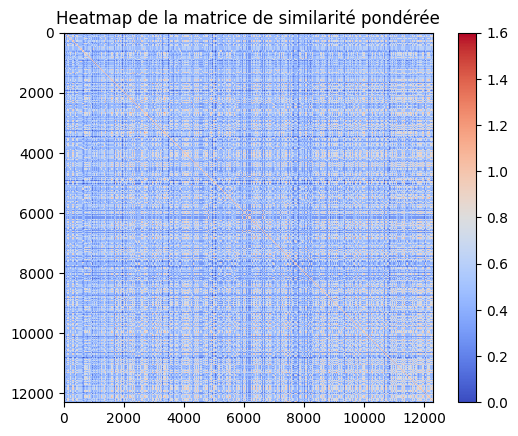

In [11]:
plt.imshow(linear_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Heatmap de la matrice de similarité pondérée')
plt.colorbar()
plt.show()

- rbf

In [23]:
rbf_matrix = np.zeros((len(df_jeux_nona), len(df_jeux_nona)))

for col, weight in tqdm(col_weights.items()):
    similarity_matrix = get_kernel_matrix(df_jeux_nona, eval(col), "rbf")
    rbf_matrix += similarity_matrix * weight

100%|██████████| 4/4 [00:18<00:00,  4.63s/it]


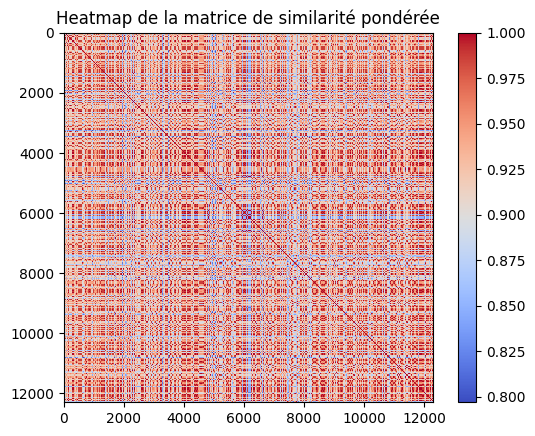

In [24]:
plt.imshow(rbf_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Heatmap de la matrice de similarité pondérée')
plt.colorbar()
plt.show()

# III. Recommandation

In [8]:
title = "Golden Horde"

In [10]:
df_jeux_nona[df_jeux_nona["titre"] == title][['titre', 'description','categories']]

,titre,description,categories
12300,Golden Horde,golden horde simulation simple rapide bataille...,guerre


In [16]:
def basic_recommand_games(matrix, df, title, nb_games=10):
    idx = df[df['titre'] == title].index[0]

    sim_scores = list(enumerate(matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [i[0] for i in sim_scores if i[0] != idx][:nb_games]

    return df.iloc[sim_scores][['titre', 'description','categories']]

In [17]:
basic_recommand_games(cosine_matrix, df_jeux_nona, title)

,titre,description,categories
9125,Men of Iron - Volume I : The Rebirth of Infantry,men of iron interess renouveau infanterie debu...,guerre
9648,The Battle for Cassino,simulation bataille nom,guerre
12274,Tigers in the Mist,simulation simple bataille ardennes,guerre
10335,Admiral,simulation bataille naval,guerre
9735,"Borodino - Battle of the Moskova, 1812",borodino partie gameplayerserie editeur americ...,guerre
6316,C.S.A America's Civil War 1861-1865,simulation guerre civil americain guerre seces...,guerre
9687,Devil's Horsemen,devil horsemen partie serie great battle of hi...,guerre
7663,The Cossacks Are Coming !,simulation niveau brigade division permettre r...,guerre
7757,Bataille de Fleurus,simulation bataille eponym,guerre
11343,La Bataille de Mont-Saint-Jean,simulation bataille waterloo,guerre


In [18]:
basic_recommand_games(linear_matrix, df_jeux_nona, title)

,titre,description,categories
9125,Men of Iron - Volume I : The Rebirth of Infantry,men of iron interess renouveau infanterie debu...,guerre
9648,The Battle for Cassino,simulation bataille nom,guerre
10136,La Bataille de Valmy,simulation bataille nom,guerre
12274,Tigers in the Mist,simulation simple bataille ardennes,guerre
11432,Army Group South,simulation,guerre
10335,Admiral,simulation bataille naval,guerre
9735,"Borodino - Battle of the Moskova, 1812",borodino partie gameplayerserie editeur americ...,guerre
6316,C.S.A America's Civil War 1861-1865,simulation guerre civil americain guerre seces...,guerre
9687,Devil's Horsemen,devil horsemen partie serie great battle of hi...,guerre
7663,The Cossacks Are Coming !,simulation niveau brigade division permettre r...,guerre


In [27]:
basic_recommand_games(rbf_matrix, df_jeux_nona, title)

,titre,description,categories
9125,Men of Iron - Volume I : The Rebirth of Infantry,men of iron interess renouveau infanterie debu...,guerre
9648,The Battle for Cassino,simulation bataille nom,guerre
12274,Tigers in the Mist,simulation simple bataille ardennes,guerre
10335,Admiral,simulation bataille naval,guerre
9735,"Borodino - Battle of the Moskova, 1812",borodino partie gameplayerserie editeur americ...,guerre
6316,C.S.A America's Civil War 1861-1865,simulation guerre civil americain guerre seces...,guerre
9687,Devil's Horsemen,devil horsemen partie serie great battle of hi...,guerre
7663,The Cossacks Are Coming !,simulation niveau brigade division permettre r...,guerre
7757,Bataille de Fleurus,simulation bataille eponym,guerre
11343,La Bataille de Mont-Saint-Jean,simulation bataille waterloo,guerre
